<a href="https://colab.research.google.com/github/SergeiVKalinin/hello-world/blob/master/MultiTask_Coregion_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ziatdinovmax/gpax.git

  Cloning https://github.com/ziatdinovmax/gpax.git to /tmp/pip-req-build-yqmjoqje
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/gpax.git /tmp/pip-req-build-yqmjoqje
  Resolved https://github.com/ziatdinovmax/gpax.git to commit 5ecb3a16c773a6ad7d4295428dbcf90b20b17d38
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 33.4 MB/s eta 0:00:00
  Created wheel for gpax: filename=gpax-0.0.7-py3-none-any.whl size=45444 sha256=4c683e2e42a4213c08af8d1b9a61ed14d67d73979b634d2c48698f70b90135d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-brgb36yd/wheels/21/c1/25/dfa8bf46ba722df764d7b29c3601f20a6f2f67ae3898e1dbf2
Successfully built gpax


Imports:

In [2]:
import gpax
import numpyro
import jax
from jax import jit
import jax.numpy as jnp

import numpy as np
import math
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

The multi-task/fidelity kernel is defined as

$$k_{multitask}(x, x', i, j) = k_{data}(x, x') \times k_{task}[i,j]$$


$$k_{task} = \mathbf{B}\mathbf{B}^T + \text{diag}(\mathbf{\kappa})$$

Here, $\mathbf{B}$ is a matrix of weights and $\mathbf{\kappa}$ is a vector of variances for each output. Both are learnable parameters. The multitask kernel function operates on two inputs $x$ and $x'$ as well as two output indices $i$ and $j$.



Let's define this multitask kernel in JAX. We assume that different tasks can have different noise levels.

In [3]:
def index_kernel(indices1, indices2, params):  # this is k_task[i,j] in the definition above
    B = params["B"]
    v = params["v"]
    covar = jnp.dot(B, B.T) + jnp.diag(v)
    return covar[jnp.ix_(indices1, indices2)]


def multi_task_kernel(X, Z, data_kernel, params, noise=None, **kwargs):
    # Extract input data and task indices from X and Z
    X_data, indices_X = X[:, :-1], X[:, -1].astype(int)
    Z_data, indices_Z = Z[:, :-1], Z[:, -1].astype(int)

    # Compute data and task kernels
    k_data = data_kernel(X_data, Z_data, params, 0, **kwargs) # no noise for data kernel - we'll add it later
    k_task = index_kernel(indices_X, indices_Z, params)

    # Compute the multi-task kernel
    K = k_data * k_task

    # Add noise associated with each task
    if X.shape == Z.shape and noise is not None:
        # Get the noise corresponding to each sample's task
        sample_noise = noise[indices_X]
        # Add the noise to the diagonal of the kernel matrix
        K = K.at[jnp.diag_indices(K.shape[0])].add(sample_noise)

    return K

Set default priors for the multitask kernel:

In [4]:
def data_kernel_prior(output_scale=False):
    # Sample data kernel length and (optionally) output scale
    k_scale = numpyro.deterministic("k_scale", jnp.array(1))
    k_length = numpyro.sample("k_length", numpyro.distributions.Gamma(2, 5))
    if output_scale:
        k_scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    # Hyperparameters are returned as a dictionary
    return {"k_length": k_length, "k_scale": k_scale}

def task_kernel_prior(n_tasks=2, rank=1):
    # Sample index kernel hyperparameters
    B  = numpyro.sample("B", numpyro.distributions.Normal(
        jnp.zeros(shape=(n_tasks, rank)), 10*jnp.ones(shape=(n_tasks, rank))))
    v = numpyro.sample("v", numpyro.distributions.LogNormal(
        jnp.zeros(shape=(n_tasks,)), jnp.ones(shape=(n_tasks,))))
    # Hyperparameters are returned as a dictionary
    return {"B": B, "v": v}

In [5]:
# A single prior sample for the task kernel
with numpyro.handlers.seed(rng_seed=1):
    task_kernel_sampled_params = task_kernel_prior()

task_kernel_sampled_params

{'B': Array([[  5.1115804 ],
        [-10.63611052]], dtype=float64),
 'v': Array([1.02576457, 0.53052964], dtype=float64)}

Next, we define a probabilistic multi-fidelity/task GP model in GPax. Notice that it is currently not a part of the GPax package.

In [6]:
from typing import Dict, Callable, Tuple, Optional
from gpax import ExactGP
from gpax.kernels import get_kernel, RBFKernel
import numpyro.distributions as dist
from functools import partial

class GPaxMultiTaskGP(ExactGP):

    def __init__(self, input_dim: int, data_kernel: str,
                 data_kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
                 task_kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
                 noise_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None
                 ) -> None:
        args = (input_dim, None)
        super(GPaxMultiTaskGP, self).__init__(*args)
        self.num_tasks = None
        self.data_kernel = data_kernel
        self.data_kernel_prior = data_kernel_prior
        self.task_kernel_prior = task_kernel_prior

    def model(self,
              X: jnp.ndarray,
              y: jnp.ndarray = None,
              **kwargs: float
              ) -> None:
        """Multitask GP probabilistic model with inputs X and targets y"""
        self.num_tasks = len(np.unique(X[:, -1]))
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])

        # Sample data kernel parameters
        if self.data_kernel_prior:
            data_kernel_params = self.data_kernel_prior()
        else:
            data_kernel_params = self._sample_kernel_params()

        # Sample task kernel parameters
        if self.task_kernel_prior:
            task_kernel_params = self.task_kernel_prior()
        else:
            task_kernel_params = self._sample_task_kernel_params()

        # Combine two dictionaries
        kernel_params = {**data_kernel_params, **task_kernel_params}

         # Sample noise
        if self.noise_prior:
            noise = self.noise_prior()
        else:  # consider using numpyro.plate here
            noise = numpyro.sample(
                "noise", dist.LogNormal(
                    jnp.zeros(self.num_tasks), jnp.ones(self.num_tasks))
            )

        # Compute multitask_kernel
        k = multi_task_kernel(X, X, self.data_kernel, kernel_params, noise)

        # Add mean function (if any)
        if self.mean_fn is not None:
            args = [X]
            if self.mean_fn_prior is not None:
                args += [self.mean_fn_prior()]
            f_loc += self.mean_fn(*args).squeeze()

        # sample y according to the standard Gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

    def _sample_kernel_params(self, output_scale: bool = False) -> Dict[str, jnp.ndarray]:
        """
        Sample kernel parameters with default
        weakly-informative log-normal priors
        """
        with numpyro.plate('k_param', self.kernel_dim):  # allows using ARD kernel for kernel_dim > 1
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1.0))
        if output_scale:
            scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        else:
            scale = numpyro.deterministic("k_scale", jnp.array(1.0))
        if self.kernel == 'Periodic':
            period = numpyro.sample("period", dist.LogNormal(0.0, 1.0))
        kernel_params = {
            "k_length": length, "k_scale": scale,
            "period": period if self.kernel == "Periodic" else None}
        return kernel_params

    @partial(jit, static_argnames='self')
    def get_mvn_posterior(self,
                          X_new: jnp.ndarray, params: Dict[str, jnp.ndarray],
                          noiseless: bool = False, **kwargs: float
                          ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Returns parameters (mean and cov) of multivariate normal posterior
        for a single sample of GP parameters
        """
        noise = params["noise"]
        noise_p = noise * (1 - jnp.array(noiseless, int))
        y_residual = self.y_train.copy()
        if self.mean_fn is not None:
            args = [self.X_train, params] if self.mean_fn_prior else [self.X_train]
            y_residual -= self.mean_fn(*args).squeeze()
        # compute kernel matrices for train and test data
        k_pp = multi_task_kernel(X_new, X_new, self.data_kernel, params, noise_p, **kwargs)
        k_pX = multi_task_kernel(X_new, self.X_train, self.data_kernel, params, jitter=0.0)
        k_XX = multi_task_kernel(self.X_train, self.X_train, self.data_kernel, params, noise, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = jnp.linalg.inv(k_XX)
        cov = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, y_residual))
        if self.mean_fn is not None:
            args = [X_new, params] if self.mean_fn_prior else [X_new]
            mean += self.mean_fn(*args).squeeze()
        return mean, cov


Generate (correlated) synthetic dataset:

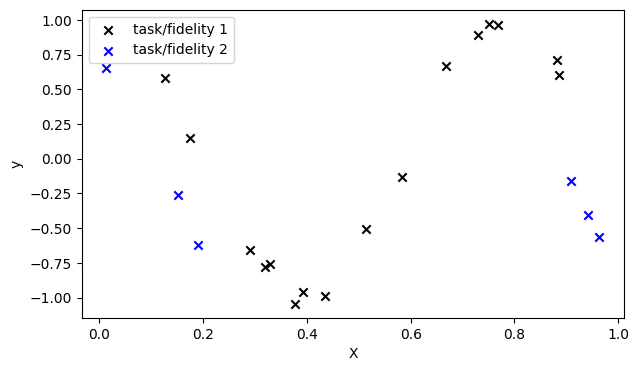

In [7]:
# Create two correlated datasets
X1 = np.random.rand(16, 1)  # Input 1 (e.g. simulations)
X2a = 0.2 * np.random.rand(3, 1) # Input 2 (e.g. experimental observations)
X2b = 0.8+0.2 * np.random.rand(3, 1)
X2 = np.concatenate([X2a, X2b])

y1 = np.cos(8 * X1) + 0.05 * np.random.randn(*X1.shape)
y2 = np.cos(8 * X2 + 0.8) + 0.1 * np.random.randn(*X2.shape)

plt.figure(figsize=(7, 4))
plt.scatter(X1, y1, marker="x", color='black', label="task/fidelity 1")
plt.scatter(X2, y2, marker="x", color='blue', label="task/fidelity 2")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

In [8]:
# Add task/fidelity indices
X = np.vstack(
    (np.hstack((X1, np.zeros_like(X1))),  # add indices associated with the fidelity/task
     np.hstack((X2, np.ones_like(X2)))) # # add indices associated with the fidelity/task
)

# We will pass target values to GP as a single array
y = np.vstack((y1, y2)).squeeze()

X.shape, y.shape

((22, 2), (22,))

Train a multi-fidelity/task GP model:

In [9]:
key1, key2 = gpax.utils.get_keys(1)

model = GPaxMultiTaskGP(1, RBFKernel, data_kernel_prior, task_kernel_prior)
model.fit(key1, X, y)

sample: 100%|██████████| 4000/4000 [00:09<00:00, 404.37it/s, 31 steps of size 1.31e-01. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    B[0,0]     -0.09      3.73     -0.26     -5.61      6.20    347.17      1.00
    B[1,0]     -0.08      2.98     -0.12     -4.33      5.22    554.50      1.00
  k_length      0.29      0.08      0.28      0.16      0.41    720.58      1.00
   k_scale      1.00      0.00      1.00      1.00      1.00       nan       nan
  noise[0]      0.02      0.02      0.02      0.00      0.04    754.42      1.00
  noise[1]      0.39      0.44      0.25      0.01      0.84    972.80      1.00
      v[0]      1.08      1.10      0.74      0.06      2.28   1236.24      1.00
      v[1]      0.95      1.02      0.64      0.04      2.05   1263.22      1.00



Make a prediction:

In [10]:
# Generate "test data" (a dense uniform grid of points covering the entire parameter space)
X_test = np.linspace(0, 1, 100)[:, None]
X_test1 = np.hstack((X_test, np.zeros_like(X_test)))
X_test2 = np.hstack((X_test, np.ones_like(X_test)))

# Make a prediction with the trained model
y_mean1, y_sampled1 = model.predict(key2, X_test1)
y_mean2, y_sampled2 = model.predict(key2, X_test2)

Plot results:

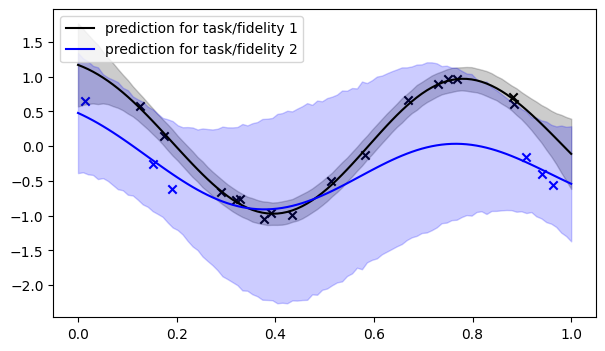

In [11]:
plt.figure(figsize=(7, 4))
plt.scatter(X1, y1, marker="x", color='black')
plt.scatter(X2, y2, marker="x", color='blue')

plt.plot(X_test[:, 0], y_mean1, color='black', label="prediction for task/fidelity 1")
plt.fill_between(X_test[:, 0],
                 y_mean1 - y_sampled1.squeeze().std(0),
                 y_mean1 + y_sampled1.squeeze().std(0),
                 alpha=0.2, color='black')
plt.plot(X_test[:, 0], y_mean2, color='blue', label="prediction for task/fidelity 2")
plt.fill_between(X_test[:, 0],
                 y_mean2 - y_sampled2.squeeze().std(0),
                 y_mean2 + y_sampled2.squeeze().std(0),
                 alpha=0.2, color='blue')
plt.legend(loc='upper left')